## 最终版本

## 引入库

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.applications.vgg16 import preprocess_input
# from keras.utils import multi_gpu_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
import numpy as np
import json
from keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50 #超显存了
from keras.applications.mobilenet import MobileNet #网络更深了

## 设置基本参数

In [2]:
batch_size = 40
epochs = 120

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

nb_training_samples = 1900
nb_validation_samples = 475 # Set parameter values

## 设置训练和验证的生成器

In [3]:
# training generator configuration
training_data_dir = './melspectrograms/training'

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ='./melspectrograms/testing/'

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 1963 images belonging to 3 classes.
Found 538 images belonging to 3 classes.


## 使用VGG16

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128

## 使用MobileNet

In [16]:
base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                           

## 使用ResNet50

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()

Model loaded.
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                             

## 建立顶层模型

In [17]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5)) #新增了一个0.5的dropout防止过拟合 keypoint****
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dropout_4 (Dropout)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 12,846,083
Trainable params: 12,846,083
Non-trainable params: 0
_________________________________________________________________


## 结合底层和顶层模型

In [18]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

## 设置优化器

In [13]:
num_layers_to_freeze = 15

In [19]:
from keras import metrics
from tensorflow.keras import optimizers

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), #将学习率由原先的1e-4降低了一个数量级
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_5_accuracy])

# serialize model to JSON
model_json = model.to_json()
model_filename = "vgg16_model_{}_frozen_layers.json".format(num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

## 模型训练

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))

# checkpoint vgg16
filepath="esc50_vgg16_stft_weights_train_last_2_base_layers.best.hdf5"
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]

# # checkpoint resnet50
# filepath="resnet50.best.hdf5"
# best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [best_model_checkpoint, tensorboard]

model.fit(
    training_generator,
    steps_per_epoch=30,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=callbacks_list)

Epoch 1/120
30/30 [==============================] - 7s 170ms/step - loss: 2.2364 - accuracy: 0.5348 - top_5_accuracy: 1.0000 - val_loss: 0.8353 - val_accuracy: 0.6599 - val_top_5_accuracy: 1.0000
Epoch 2/120
29/30 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.8483 - top_5_accuracy: 1.0000

In [10]:
def get_top_k_predictions(preds, label_map, k=5, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

## 标签编码以及预测

In [13]:
label_map = (training_generator.class_indices)
 
# json = json.dumps(label_map)
# f = open("cough_label_map.json","w")
# f.write(json)
# f.close()

img_path = './melspectrograms/testing/heavyload/heavyload_talking_3_2.png'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]


In [15]:
get_top_k_predictions(preds, label_map, k=3)

['heavyload', 'good', 'broken']

In [14]:
get_top_k_predictions(preds, label_map, k=1)[0]

'heavyload'

## 存储模型

In [16]:
model.save('ENGINE_99.h5')

## 计算并绘制混淆矩阵

In [17]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


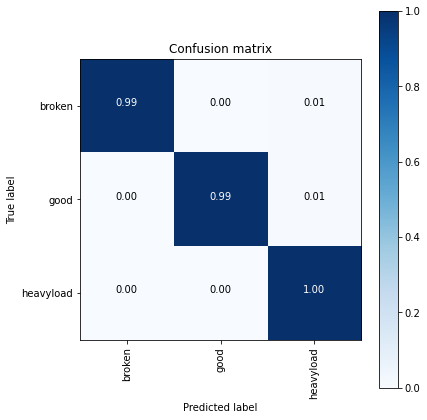

In [18]:
from sklearn.metrics import confusion_matrix
import os
testing_dir = './melspectrograms/testing/'

y_true = []
y_pred = []
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        img_path = testing_dir + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)

## 模型载入以及测试

In [20]:
model_test = load_model('ENGINE_99.h5', custom_objects={'top_5_accuracy': top_5_accuracy} )

In [28]:
img_path = './melspectrograms/testing/broken/broken_talking_3_5.png'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model_test.predict(x)[0]

In [29]:
preds

array([9.997831e-01, 1.486927e-04, 6.813546e-05], dtype=float32)

In [ ]:
max_index = np.argmax(np.array(preds))

In [33]:
max_index

0

In [25]:
label_map

{'broken': 0, 'good': 1, 'heavyload': 2}